# Feature variation by substitution ($\nu_{\phi}$)

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count', 'synonyms_count']
N_COMPONENTS = 3

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from progressbar import ProgressBar

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope
engine = init_db()

## 2 Variation of features upon substitution

First build our data.

In [3]:
model = Model(Time.discrete, Source.majority, Past.last_bin, Durl.all)
data = []

with session_scope() as session:
    substitutions = session.query(Substitution.id).filter(Substitution.model == model)
    print("Got {} substitutions for model {}".format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar()(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for feature in Substitution.__features__:
            source, destination = substitution.features(feature)
            source_rel, destination_rel = substitution.features(feature, sentence_relative=True)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'feature': feature,
                         'source': source,
                         'source_rel': source_rel,
                         'destination': destination,
                         'destination_rel': destination_rel,
                         'h0': substitution.feature_average(feature),
                         'h0_rel': substitution.feature_average(feature,
                                                                sentence_relative=True),
                         'h0n': substitution.feature_average(feature,
                                                             source_synonyms=True),
                         'h0n_rel': substitution.feature_average(feature,
                                                                 source_synonyms=True,
                                                                 sentence_relative=True)})

original_variations = pd.DataFrame(data)
del data

Got 9071 substitutions for model Model(time=Time.discrete, source=Source.majority, past=Past.last_bin, durl=Durl.all)


100% (9071 of 9071) |#######################################################################################################################################| Elapsed Time: 0:02:30 Time: 0:02:30


Compute cluster averages (so as not to overestimate confidence intervals) and crop data so that we have acceptable CIs.

In [4]:
variations = original_variations\
    .groupby(['destination_id', 'occurrence', 'feature'], as_index=False).mean()\
    .groupby(['cluster_id', 'feature'], as_index=False)\
    ['source', 'source_rel', 'destination', 'destination_rel', 'feature',
     'h0', 'h0_rel', 'h0n', 'h0n_rel'].mean()
variations['variation'] = variations['destination'] - variations['source']

# HARDCODED: drop values where source AoA is above 15.
# This crops the graphs to acceptable CIs.
variations.loc[(variations.feature == 'aoa') & (variations.source > 15),
               ['source', 'source_rel', 'destination', 'destination_rel',
                'h0', 'h0_rel', 'h0n', 'h0n_rel']] = np.nan

### 2.1 What we plot about features

For a feature $\phi$, plot:

* $\nu_{\phi}$, the variation of the feature upon substitution
* $\nu_{\phi}^0$ (which is the average feature value), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi}^{00}$ (which is the average feature value for synonyms of the source word), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

We also plot these values relative to the sentence average, i.e.:

* $\nu_{\phi, r}$, the variation, upon substitution, of the changing word's feature compared to the sentence average, i.e. $f($destination$) - f($destination sentence$) - (f($source$) - f($source sentence$))$
* $\nu_{\phi, r}^0$ (which is the average feature value minus the sentence average), i.e. what happens under $\mathcal{H}_0$
* $\nu_{\phi, r}^{00}$ (which is the average feature value for synonyms of the source word minus the sentence average), i.e. what happens under $\mathcal{H}_{00}$
* $y = x$, i.e. what happens if there is no substitution

Those values are plotted below in two groups each time, first the absolute feature values, then the relative-to-sentence features.

In [5]:
def plot_variation(x, y, **kwargs):
    data = kwargs.pop('data')
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    rel = '_rel' if relative else ''
    x = data[x + rel]
    y = data[y + rel]
    h0 = data['h0' + rel]
    h0n = data['h0n' + rel]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    middles = (bins[:-1] + bins[1:]) / 2
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        h0s[i] = h0[x_bins == i].mean()
        h0ns[i] = h0n[x_bins == i].mean()
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    nuphi = r'\nu_{\phi' + (',r' if relative else '') + '}'
    plt.plot(middles, values, '-', lw=2, color=color, label='${}$'.format(nuphi))
    plt.fill_between(middles, values - cis, values + cis,
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, h0s, '--', color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(nuphi))
    plt.plot(middles, h0ns, linestyle='-.', color=sb.desaturate(color, 0.2),
             label='${}^{{00}}$'.format(nuphi))
    plt.plot(middles, middles, linestyle='dotted', color=sb.desaturate(color, 0.2),
             label='$y = x$')
    lmin, lmax = middles[0], middles[-1]
    h0min, h0max = min(h0s.min(), h0ns.min()), max(h0s.max(), h0ns.max())
    # Rescale limits if we're touching H0 or H00.
    if h0min < lmin:
        lmin = h0min - (lmax - h0min) / 10
    elif h0max > lmax:
        lmax = h0max + (h0max - lmin) / 10
    plt.xlim(lmin, lmax)
    plt.ylim(lmin, lmax)

In [6]:
def plot_bias(ax, data, color, ci=True, relative=False):
    feature = data.iloc[0].feature
    rel = '_rel' if relative else ''
    x = data['source' + rel]
    y = data['destination' + rel]
    h0 = data['h0' + rel]
    h0n = data['h0n' + rel]
    
    # Compute binning.
    bin_count = 4
    x_bins, bins = pd.cut(x, bin_count, right=False, labels=False, retbins=True)
    
    # Compute bin values.
    h0s = np.zeros(bin_count)
    h0ns = np.zeros(bin_count)
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        h0s[i] = h0[x_bins == i].mean()
        h0ns[i] = h0n[x_bins == i].mean()
        values[i] = y[x_bins == i].mean()
        cis[i] = 1.96 * y[x_bins == i].std() / np.sqrt((x_bins == i).sum() - 1)
    
    # Plot.
    ax.plot(np.linspace(0, 1, bin_count), (values - h0ns) / h0s.mean(), '-', lw=2, color=color,
            label=Substitution._transformed_feature(feature).__doc__)
    if ci:
        ax.fill_between(np.linspace(0, 1, bin_count),
                        (values - h0ns - cis) / h0s.mean(), (values - h0ns + cis) / h0s.mean(),
                        color=sb.desaturate(color, 0.2), alpha=0.2)        

### 2.2 All feature variations

For each feature $\phi$, we plot the variation upon substitution as explained above

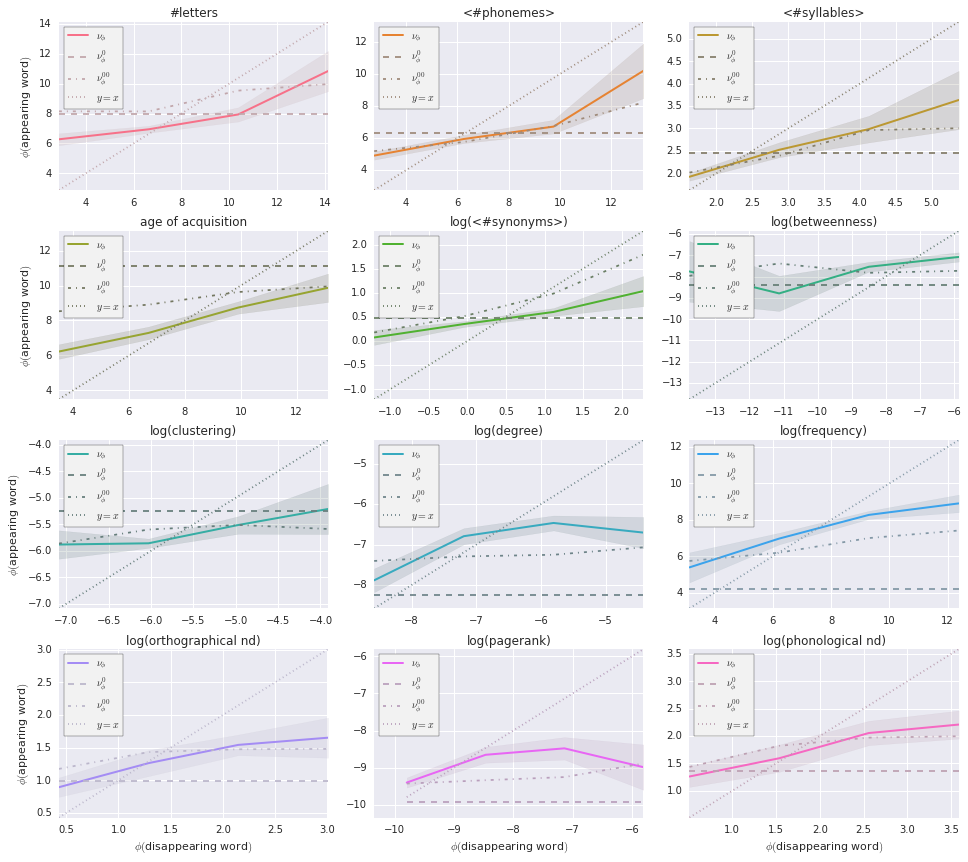

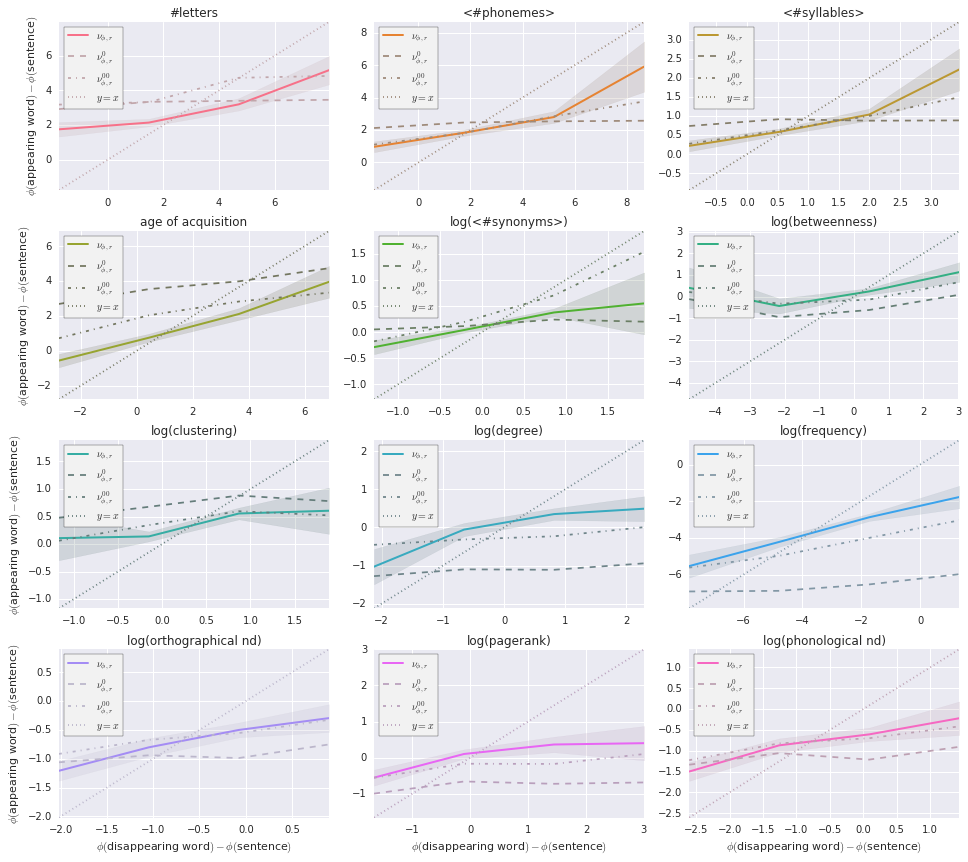

In [7]:
ordered_features = sorted(Substitution.__features__,
                          key=lambda f: Substitution._transformed_feature(f).__doc__)
g = sb.FacetGrid(data=variations, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$)$')
g.set_ylabels(r'$\phi($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

# With sentence_relative features
g = sb.FacetGrid(data=variations, col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=ordered_features, hue_order=ordered_features)
g.map_dataframe(plot_variation, 'source', 'destination', relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$) - \phi($sentence$)$')
g.set_ylabels(r'$\phi($appearing word$) - \phi($sentence$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

Then plot $\nu_{\phi} - \nu_{\phi}^{00}$ for each feature (i.e. the measured bias) to see how they compare

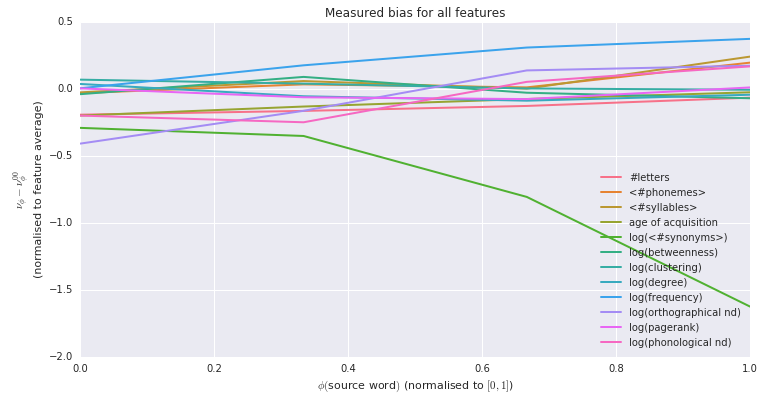

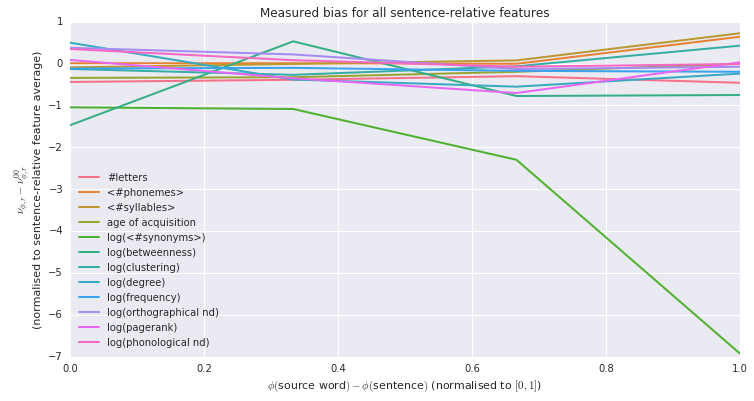

In [8]:
palette = sb.color_palette('husl', len(Substitution.__features__))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(ordered_features):
    plot_bias(ax, variations[variations['feature'] == feature],
              color=palette[j], ci=False)
ax.legend(loc='lower right')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')

# With sentence_relative features
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(ordered_features):
    plot_bias(ax, variations[variations['feature'] == feature],
              color=palette[j], ci=False, relative=True)
ax.legend(loc='lower left')
ax.set_title('Measured bias for all sentence-relative features')
ax.set_xlabel(r'$\phi($source word$) - \phi($sentence$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi,r} - \nu_{\phi,r}^{00}$' +
              '\n(normalised to sentence-relative feature average)')

### 2.3 Feature variations, reduced to features we expose in the paper

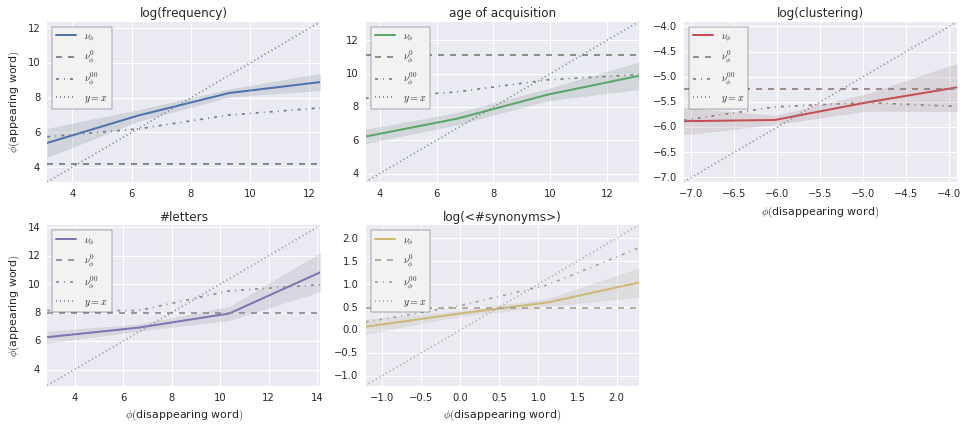

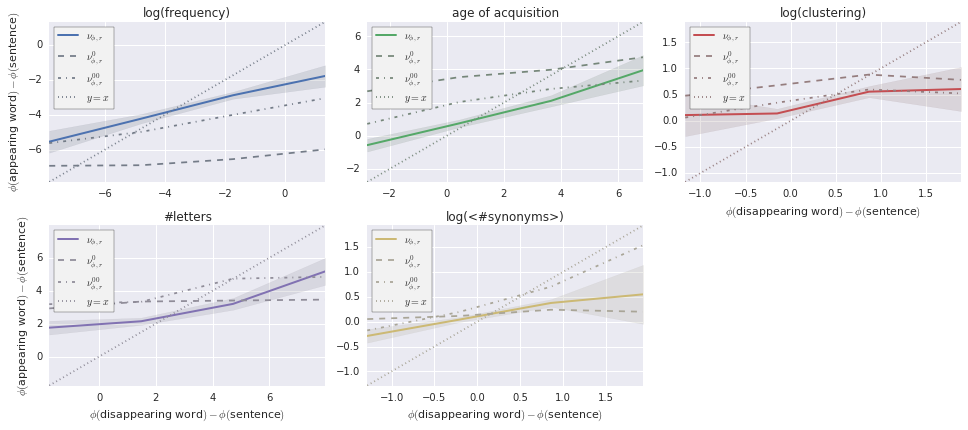

In [9]:
g = sb.FacetGrid(data=variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$)$')
g.set_ylabels(r'$\phi($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

# With sentence_relative features
g = sb.FacetGrid(data=variations[variations['feature'].map(lambda f: f in PAPER_FEATURES)],
                 col='feature', col_wrap=3,
                 sharex=False, sharey=False, hue='feature',
                 aspect=1.5, size=3,
                 col_order=PAPER_FEATURES, hue_order=PAPER_FEATURES)
g.map_dataframe(plot_variation, 'source', 'destination', relative=True)
g.set_titles('{col_name}')
g.set_xlabels(r'$\phi($disappearing word$) - \phi($sentence$)$')
g.set_ylabels(r'$\phi($appearing word$) - \phi($sentence$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')
    ax.set_title(Substitution._transformed_feature(ax.get_title()).__doc__)

And the same with features relative to sentence average

Now $\nu_{\phi} - \nu_{\phi}^{00}$

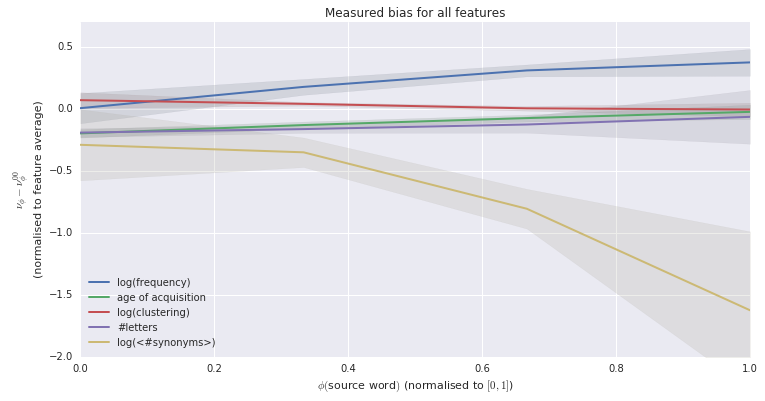

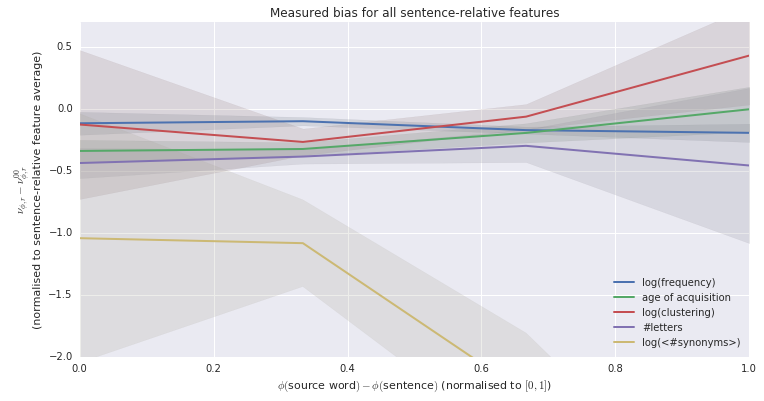

In [10]:
palette = sb.color_palette('deep', len(PAPER_FEATURES))
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(PAPER_FEATURES):
    plot_bias(ax, variations[variations['feature'] == feature],
              color=palette[j])
ax.legend(loc='lower left')
ax.set_title('Measured bias for all features')
ax.set_xlabel(r'$\phi($source word$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi} - \nu_{\phi}^{00}$' + '\n(normalised to feature average)')
ax.set_ylim(-2, .7)

# With sentence_relative features
fig, ax = plt.subplots(figsize=(12, 6))
for j, feature in enumerate(PAPER_FEATURES):
    plot_bias(ax, variations[variations['feature'] == feature],
              color=palette[j], relative=True)
ax.legend(loc='lower right')
ax.set_title('Measured bias for all sentence-relative features')
ax.set_xlabel(r'$\phi($source word$) - \phi($sentence$)$ (normalised to $[0, 1]$)')
ax.set_ylabel(r'$\nu_{\phi,r} - \nu_{\phi,r}^{00}$' +
              '\n(normalised to sentence-relative feature average)')
ax.set_ylim(-2, .7);

## 3 PCA'd feature variations

Compute PCA on feature *variations* (note: on variations, not on features directly), and show the evolution of the first three components upon substitution.

**CAVEAT**: the PCA is computed on variations where all features are defined. This greatly reduces the number of words included (and also the number of substitutions -- see below for real values, but you should know it's drastic). This also has an effect on the computation of $\mathcal{H}_0$ and $\mathcal{H}_{00}$, which are computed using words for which all features are defined. This, again, hugely reduces the number of words taken into account.

### 3.1 On all the features

Compute the actual PCA

In [11]:
# Compute the PCA.
pcafeatures = tuple(sorted(Substitution.__features__))
pcavariations = variations.pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:".format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=pcafeatures,
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 11 components.

Those explain the following variance:
[ 0.51446555  0.17489229  0.09027657  0.07328873  0.03525223  0.03035294
  0.02269237  0.01956296  0.01551358  0.01115776  0.0074942 ]

We're plotting variation for the first 3 components:


,aoa,betweenness,clustering,degree,frequency,letters_count,orthographical_density,pagerank,phonemes_count,phonological_density,syllables_count,synonyms_count
Component-0,-0.494620,0.285122,-0.096906,0.244552,0.220021,-0.428082,0.209175,0.260700,-0.394800,0.281829,-0.161557,0.009108
Component-1,-0.376832,0.347266,-0.102316,0.279024,0.226340,0.457246,-0.161054,0.302833,0.446615,-0.218316,0.153843,-0.018360
Component-2,-0.533138,-0.059417,0.030610,-0.028758,-0.835564,0.075649,0.004000,-0.056422,-0.009812,-0.042775,-0.007291,0.037434


Compute the source and destination component values, along with $\mathcal{H}_0$ and $\mathcal{H}_{00}$, for each component.

In [12]:
data = []
for substitution_id in ProgressBar()(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for component in range(N_COMPONENTS):
            source, destination = substitution.components(component, pca, pcafeatures)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'component': component,
                         'source': source,
                         'destination': destination,
                         'h0': substitution.component_average(component, pca, pcafeatures),
                         'h0n': substitution.component_average(component, pca, pcafeatures,
                                                               source_synonyms=True)})

original_component_variations = pd.DataFrame(data)
del data

100% (9071 of 9071) |#######################################################################################################################################| Elapsed Time: 0:01:58 Time: 0:01:58


Compute cluster averages (so as not to overestimate confidence intervals).

In [13]:
component_variations = original_component_variations\
    .groupby(['destination_id', 'occurrence', 'component'], as_index=False).mean()\
    .groupby(['cluster_id', 'component'], as_index=False)\
    ['source', 'destination', 'component', 'h0', 'h0n'].mean()

Plot the actual variations of components (**see the caveat section below**)

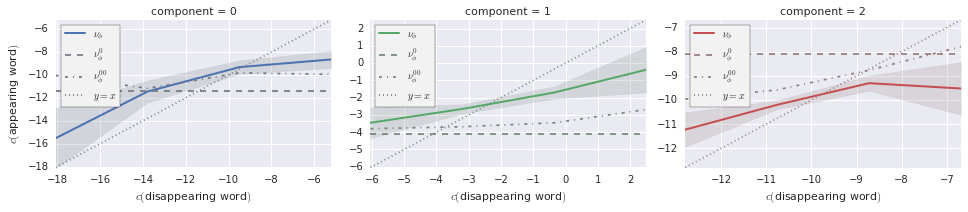

In [14]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_xlabels(r'$c($disappearing word$)$')
g.set_ylabels(r'$c($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')

### 3.2 On the features we expose in the paper

Compute the actual PCA

In [15]:
# Compute the PCA.
pcafeatures = tuple(sorted(PAPER_FEATURES))
pcavariations = variations[variations['feature'].map(lambda f: f in pcafeatures)]\
    .pivot(index='cluster_id', columns='feature', values='variation')
pcavariations = pcavariations.dropna()
pca = PCA(n_components='mle')
pca.fit(pcavariations)

# Show 
print('MLE estimates there are {} components.\n'.format(pca.n_components_))
print('Those explain the following variance:')
print(pca.explained_variance_ratio_)
print()

print("We're plotting variation for the first {} components:".format(N_COMPONENTS))
pd.DataFrame(pca.components_[:N_COMPONENTS],
             columns=pcafeatures,
             index=['Component-{}'.format(i) for i in range(N_COMPONENTS)])

MLE estimates there are 3 components.

Those explain the following variance:
[ 0.56333174  0.20086225  0.16434947]

We're plotting variation for the first 3 components:


,aoa,clustering,frequency,letters_count,synonyms_count
Component-0,-0.737684,-0.104895,0.296954,-0.597086,0.011231
Component-1,0.600471,0.082393,-0.071504,-0.792100,-0.010499
Component-2,-0.294571,0.133034,-0.937584,-0.125205,0.028118


Compute the source and destination component values, along with $\mathcal{H}_0$ and $\mathcal{H}_{00}$, for each component.

In [16]:
data = []
for substitution_id in ProgressBar()(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        for component in range(N_COMPONENTS):
            source, destination = substitution.components(component, pca, pcafeatures)
            data.append({'cluster_id': substitution.source.cluster.sid,
                         'destination_id': substitution.destination.sid,
                         'occurrence': substitution.occurrence,
                         'source_id': substitution.source.sid,
                         'component': component,
                         'source': source,
                         'destination': destination,
                         'h0': substitution.component_average(component, pca, pcafeatures),
                         'h0n': substitution.component_average(component, pca, pcafeatures,
                                                               source_synonyms=True)})

original_component_variations = pd.DataFrame(data)
del data

100% (9071 of 9071) |#######################################################################################################################################| Elapsed Time: 0:01:24 Time: 0:01:24


Compute cluster averages (so as not to overestimate confidence intervals).

In [17]:
component_variations = original_component_variations\
    .groupby(['destination_id', 'occurrence', 'component'], as_index=False).mean()\
    .groupby(['cluster_id', 'component'], as_index=False)\
    ['source', 'destination', 'component', 'h0', 'h0n'].mean()

Plot the actual variations of components

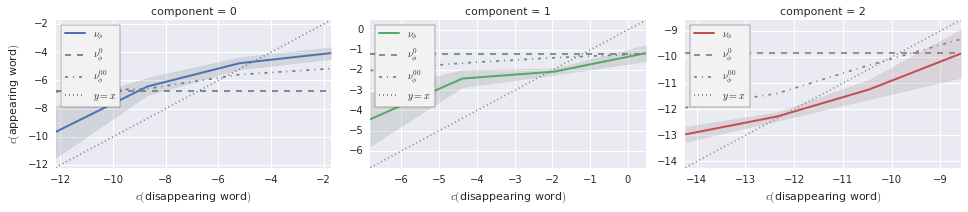

In [18]:
g = sb.FacetGrid(data=component_variations, col='component', col_wrap=3,
                 sharex=False, sharey=False, hue='component',
                 aspect=1.5, size=3)
g.map_dataframe(plot_variation, 'source', 'destination')
g.set_xlabels(r'$c($disappearing word$)$')
g.set_ylabels(r'$c($appearing word$)$')
for ax in g.axes.ravel():
    legend = ax.legend(frameon=True, loc='upper left')
    if not legend:
        # Skip if nothing was plotted on these axes.
        continue
    frame = legend.get_frame()
    frame.set_facecolor('#f2f2f2')
    frame.set_edgecolor('#000000')

### 3.3 CAVEAT: reduction of the numbers of words and substitutions

As explained above, this PCA analysis can only use words for which *all* the features are defined (in this case, the features listed in `PAPER_FEATURES`). So note the following:

In [19]:
for feature in PAPER_FEATURES:
    print("Feature '{}' is based on {} words."
          .format(feature, len(Substitution._transformed_feature(feature)())))

# Compute the number of words that have all PAPER_FEATURES defined.
words = set()
for tfeature in [Substitution._transformed_feature(feature) for feature in PAPER_FEATURES]:
    words.update(tfeature())

data = dict((feature, []) for feature in PAPER_FEATURES)
words_list = []
for word in words:
    words_list.append(word)
    for feature in PAPER_FEATURES:
        data[feature].append(Substitution._transformed_feature(feature)(word))
wordsdf = pd.DataFrame(data)
wordsdf['words'] = words_list
del words_list, data

print()
print("Among all the set of words used by these features, only {} are used."
      .format(len(wordsdf.dropna())))

print()
print("Similarly, we mined {} (cluster-unique) substitutions, but the PCA is in fact"
      " computed on {} of them (those where all features are defined)."
      .format(len(set(variations['cluster_id'])), len(pcavariations)))

Feature 'frequency' is based on 33450 words.
Feature 'aoa' is based on 30102 words.
Feature 'clustering' is based on 5739 words.
Feature 'letters_count' is based on 42786 words.
Feature 'synonyms_count' is based on 147306 words.

Among all the set of words used by these features, only 4073 are used.

Similarly, we mined 1061 (cluster-unique) substitutions, but the PCA is in fact computed on 369 of them (those where all features are defined).


The way $\mathcal{H}_0$ and $\mathcal{H}_{00}$ are computed makes them also affected by this.